## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Transformations

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(size=244),
    transforms.CenterCrop(size=244),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(size=244),
    transforms.CenterCrop(size=244),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

## Loading Dataset

In [4]:
data_directory = 'data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(data_directory, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_directory, 'test'), transform=test_transform)

In [5]:
train_data

Dataset ImageFolder
    Number of datapoints: 18743
    Root location: data/CATS_DOGS/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=244, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(244, 244))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
test_data

Dataset ImageFolder
    Number of datapoints: 6251
    Root location: data/CATS_DOGS/test
    StandardTransform
Transform: Compose(
               Resize(size=244, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(244, 244))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=False)

In [8]:
class_names = train_data.classes
class_names

['CAT', 'DOG']

## Examine Batch of Images

In [9]:
for images, labels in train_loader:
    break

In [10]:
images.shape

torch.Size([10, 3, 244, 244])

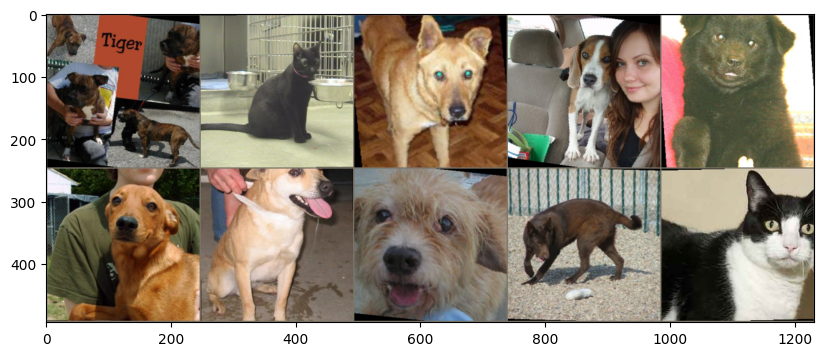

In [11]:
img = make_grid(images, nrow=5)

inverse_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

inverse_img = inverse_transform(img)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(inverse_img.numpy(), (1, 2, 0)))

## Creating the Model

In [12]:
images[0].shape

torch.Size([3, 244, 244])

In [13]:
(((244-2)/2)-2)/2

59.5

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=59*59*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = X.view(-1, 59*59*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [15]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=55696, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [16]:
parameter_list = []
for param in model.parameters():
    parameter_list.append(param.numel())

print(f"Total Number of Parameters: {sum(parameter_list)}")

Total Number of Parameters: 6695022


## Training the Model

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
import time
start_time = time.time()

epochs = 5
max_train_batch = 800
max_test_batch = 300

train_losses_list = []
test_losses_list = []
train_correct_list = []
test_correct_list = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        if batch == max_train_batch:
            break
            
        batch += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            print(f"EPOCH: {i} BATCH: {batch} LOSS: {loss.item()} ACCURACY: {train_correct.item()*100/(batch*10):7.3f}%")

    train_losses_list.append(loss.detach().numpy())
    train_correct_list.append(train_correct)

    # Testing
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            if batch == max_test_batch:
                break
            
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses_list.append(loss.detach().numpy())
    test_correct_list.append(test_correct)


current_time = time.time()
total_time = current_time - start_time
print(f"Training Took {total_time/60} minutes")

EPOCH: 0 BATCH: 200 LOSS: 0.754673957824707 ACCURACY:  54.300%
EPOCH: 0 BATCH: 400 LOSS: 0.6469917893409729 ACCURACY:  57.200%
EPOCH: 0 BATCH: 600 LOSS: 0.39719158411026 ACCURACY:  59.800%
EPOCH: 0 BATCH: 800 LOSS: 0.5553392171859741 ACCURACY:  61.400%
EPOCH: 1 BATCH: 200 LOSS: 0.7797945141792297 ACCURACY:  68.250%
EPOCH: 1 BATCH: 400 LOSS: 0.3455597758293152 ACCURACY:  68.700%
EPOCH: 1 BATCH: 600 LOSS: 0.5383251905441284 ACCURACY:  69.167%
EPOCH: 1 BATCH: 800 LOSS: 0.47228091955184937 ACCURACY:  69.487%
EPOCH: 2 BATCH: 200 LOSS: 0.5301282405853271 ACCURACY:  73.700%
EPOCH: 2 BATCH: 400 LOSS: 0.7534674406051636 ACCURACY:  73.750%
EPOCH: 2 BATCH: 600 LOSS: 0.7324473857879639 ACCURACY:  73.217%
EPOCH: 2 BATCH: 800 LOSS: 0.4327842593193054 ACCURACY:  72.537%
EPOCH: 3 BATCH: 200 LOSS: 0.579190194606781 ACCURACY:  75.750%
EPOCH: 3 BATCH: 400 LOSS: 0.30826473236083984 ACCURACY:  75.750%
EPOCH: 3 BATCH: 600 LOSS: 0.5768100023269653 ACCURACY:  75.283%
EPOCH: 3 BATCH: 800 LOSS: 0.39488500356674

## Save the Model

In [19]:
torch.save(model.state_dict(), 'cats_and_dogs_model.pt')

## Evaluation

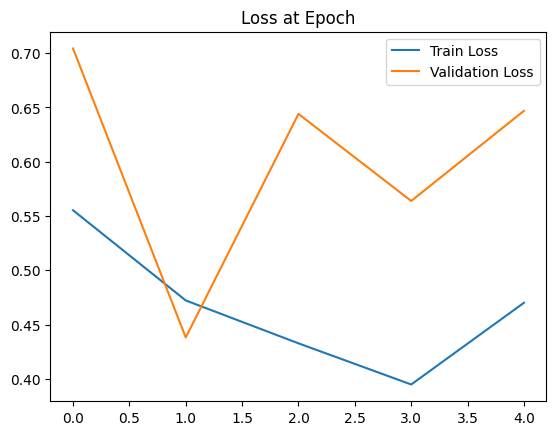

In [20]:
plt.plot(train_losses_list, label='Train Loss')
plt.plot(test_losses_list, label='Validation Loss')
plt.title("Loss at Epoch")
plt.legend();

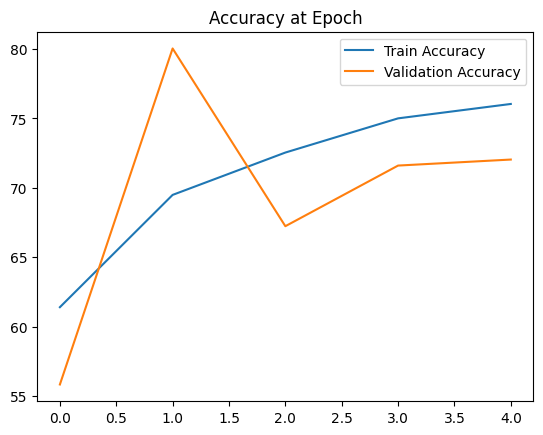

In [21]:
plt.plot([train/80 for train in train_correct_list], label='Train Accuracy')
plt.plot([test/30 for test in test_correct_list], label='Validation Accuracy')
plt.title("Accuracy at Epoch")
plt.legend();

## Passing the Image

In [22]:
inverse_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [23]:
image_index = 2019

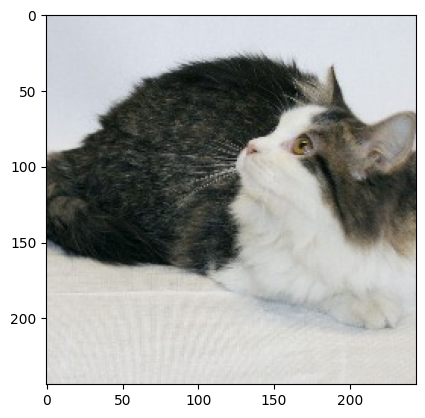

In [24]:
im = inverse_transform(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [25]:
model.eval()

with torch.no_grad():
    new_prediction = model(test_data[image_index][0].view(1, 3, 244, 244)).argmax()

class_names[new_prediction.item()]

'CAT'